<a href="https://colab.research.google.com/github/mjokeit/PINN_heat/blob/master/notebooks/1Dheat_Neumann_nondim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINN for continuous-time solution of nondimenionalized heat equation

First, check if GPU hardware acceleration is selected in "Runtime" -> "Change runtime type".

# mount google drive (optional)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

if you want to access/store files directly in your google drive

In [ ]:
# import os
# if os.getcwd() != '/content/drive/My Drive/Colab Notebooks/PINNs':
#   os.chdir('/content/drive/My Drive/Colab Notebooks/PINNs')

# download data

In [ ]:
!wget https://github.com/mjokeit/PINN_heat/raw/master/continuous_time_inference/data/heat1D_nondim.mat

--2020-07-31 16:38:03--  https://github.com/mjokeit/PINN_heat/raw/master/continuous_time_inference/data/heat1D_nondim.mat
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mjokeit/PINN_heat/master/continuous_time_inference/data/heat1D_nondim.mat [following]
--2020-07-31 16:38:04--  https://raw.githubusercontent.com/mjokeit/PINN_heat/master/continuous_time_inference/data/heat1D_nondim.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 820537 (801K) [application/octet-stream]
Saving to: ‘heat1D_nondim.mat.2’

heat1D_nondim.mat.2 100%[===================>] 801.31K  --.-KB/s    in 0.07s   

2020-07-31

# install pyDOE

In [ ]:
!pip install -q pyDOE

# import plotting

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Oct  9 20:11:57 2017

@author: mraissi
"""

import numpy as np
import matplotlib

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean =  1/0.707 # (np.sqrt(5.0)-1.0)/2.0       # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
        fig = plt.gcf()
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        fig.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        fig.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
        fig = plt.gcf()
#        plt.savefig('{}.pgf'.format(filename))
        fig.savefig('{}.pdf'.format(filename))
        fig.savefig('{}.eps'.format(filename))

# PINN class

In [ ]:
"""
@author: Maziar Raissi
@editor: Moritz Jokeit
"""

import sys

sys.path.insert(0, '../utilities')

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(1234)
tf.set_random_seed(1234)



class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, tb, X_f, X_f_val, layers, lb, ub, min_max_f, X_star, u_star, max_iter):

        X0 = np.concatenate((x0, 0 * x0), 1)  # (x0, 0)
        X_lb = np.concatenate((0 * tb + lb[0], tb), 1)  # (lb[0], tb)
        X_ub = np.concatenate((0 * tb + ub[0], tb), 1)  # (ub[0], tb)

        self.lb = lb
        self.ub = ub

        self.X_star = X_star
        self.u_star = u_star

        self.min_f = min_max_f[0]
        self.max_f = min_max_f[1]

        self.x0 = X0[:, 0:1]
        self.t0 = X0[:, 1:2]

        self.x_lb = X_lb[:, 0:1]
        self.t_lb = X_lb[:, 1:2]

        self.x_ub = X_ub[:, 0:1]
        self.t_ub = X_ub[:, 1:2]

        self.x_f = X_f[:, 0:1]
        self.t_f = X_f[:, 1:2]

        self.x_f_val = X_f_val[:, 0:1]
        self.t_f_val = X_f_val[:, 1:2]

        self.u0 = u0

        self.log_var_u0 = tf.Variable(1.0, dtype='float32')
        self.log_var_ub = tf.Variable(1.0, dtype='float32')
        self.log_var_f = tf.Variable(1.0, dtype='float32')

        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)

        # tf Placeholders
        self.training = tf.placeholder(tf.bool)
        self.penalties = tf.placeholder(tf.float32, shape=(3))

        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])

        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])

        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])

        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])

        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        self.x_f_tf_val = tf.placeholder(tf.float32, shape=[None, self.x_f_val.shape[1]])
        self.t_f_tf_val = tf.placeholder(tf.float32, shape=[None, self.t_f_val.shape[1]])

        self.X_star_tf = tf.placeholder(tf.float32, shape=[None, self.X_star.shape[1]])

        # tf Graphs
        self.u0_pred, self.u0_x_pred = self.net_u(self.x0_tf, self.t0_tf)
        self.u_lb_pred, self.u_x_lb_pred = self.net_u(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred, self.u_x_ub_pred = self.net_u(self.x_ub_tf, self.t_ub_tf)
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)
        self.s_pred = self.net_s(self.x_f_tf, self.t_f_tf)
        self.f_pred_val = self.net_f(self.x_f_tf_val, self.t_f_tf_val)
        self.s_pred_val = self.net_s(self.x_f_tf_val, self.t_f_tf_val)
        self.u_pred, _ = self.net_u(self.X_star_tf[:, 0:1], self.X_star_tf[:, 1:2])

        self.delta_u0 = tf.reduce_mean(self.u0_pred - self.u0_tf)

        # MIN-MAX-SCALING BETWEEN [-sf, sf]
        # sf = 1  # scale factor
        # self.scaled_u0_tf = 2*sf * (self.u0_tf - tf.reduce_min(self.u0_tf)) / \
        #                       (tf.reduce_max(self.u0_tf) - tf.reduce_min(self.u0_tf)) - sf
        # self.scaled_u0_pred = 2*sf * (self.u0_pred - tf.reduce_min(self.u0_tf)) / \
        #                       (tf.reduce_max(self.u0_tf) - tf.reduce_min(self.u0_tf)) - sf
        # self.scaled_u_x_lb_pred = 2*sf*(self.u_x_lb_pred + 2e4) / (2e4 + 2e4) - sf
        # self.scaled_u_x_ub_pred = 2*sf*(self.u_x_ub_pred + 2e4) / (2e4 + 2e4) - sf
        # self.scaled_f_pred = 2*sf * (self.f_pred - self.min_f) / \
        #                      (self.max_f - self.min_f) - sf
        # self.scaled_s_pred = 2*sf * (self.s_pred - self.min_f) / \
        #                      (self.max_f - self.min_f) - sf
        # self.scaled_f_pred_val = self.min_max_scale(self.f_pred_val, self.min_f, self.max_f)
        # self.scaled_s_pred_val = self.min_max_scale(self.s_pred_val, self.min_f, self.max_f)

        # MAX ABS SCALING
        abs_max_f = tf.cast(tf.reduce_max(tf.abs(min_max_f)), 'float32')
        abs_max_u0 = tf.cast(tf.reduce_max(tf.abs(self.u0_tf)), 'float32')
        self.scaled_u0_tf = self.u0_tf / abs_max_u0
        self.scaled_u0_pred = self.u0_pred / abs_max_u0
        self.scaled_u_x_lb_pred = self.u_x_lb_pred
        self.scaled_u_x_ub_pred = self.u_x_ub_pred
        self.scaled_f_pred = self.f_pred / abs_max_f
        self.scaled_s_pred = self.s_pred / abs_max_f
        self.scaled_f_pred_val = self.f_pred_val / abs_max_f
        self.scaled_s_pred_val = self.s_pred_val / abs_max_f

        # SCALED LOSSES FOR ADAPTIVE COST FUNCTION
        self.loss_u0 = tf.reduce_mean(tf.square(self.scaled_u0_tf - self.scaled_u0_pred))
        self.loss_ub = tf.reduce_mean(tf.square(self.scaled_u_x_lb_pred)) +\
                       tf.reduce_mean(tf.square(self.scaled_u_x_ub_pred))
        self.loss_f = tf.reduce_mean(tf.square(self.scaled_f_pred - self.scaled_s_pred))
        self.val_loss_f = tf.reduce_mean(tf.square(self.scaled_f_pred_val - self.scaled_s_pred_val))

        # STANDARD LOSSES WITH OPTIONAL PENALTY FACTORS (penalties default to 1)
        # ACTIVATE FOR OPTIONAL AUTO RESCALING AFTER FIRST ITERATIONS
        # self.loss_u0 = self.penalties[0] * tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred))
        # self.loss_ub = self.penalties[1] * (tf.reduce_mean(tf.square(self.u_x_lb_pred)) +
        #                                     tf.reduce_mean(tf.square(self.u_x_ub_pred)))
        # self.loss_f = self.penalties[2] * tf.reduce_mean(tf.square(self.f_pred - self.s_pred))
        # self.val_loss_f = tf.reduce_mean(tf.square(self.f_pred_val - self.s_pred_val))

        # LOSS FORMULATION FOR AUTO ADAPTIVE LOSS (NOT STABLE)
        # self.loss_u0 = tf.sqrt(tf.reduce_sum(tf.square(self.u0_tf - self.u0_pred)))
        # self.loss_ub = tf.sqrt(tf.reduce_sum(tf.square(self.u_x_lb_pred)) + tf.reduce_sum(tf.square(self.u_x_ub_pred)))
        # self.loss_f = tf.sqrt(tf.reduce_sum(tf.square(self.f_pred - self.s_pred)))
        # self.val_loss_f = tf.reduce_mean(tf.square(self.f_pred_val - self.s_pred_val))

        self.loss = self.loss_u0 + self.loss_ub + self.loss_f

        # ALTERNATIVE LOSS FORMULATIONS
        # self.loss = tf.log(self.loss_u0 +1) + tf.log(self.loss_ub + 1) + tf.log(self.loss_f + 1) # TEST OF A SIMPLE LOG LOSS
        # self.loss = self.adaptive_loss() # promising weighted loss approach https://arxiv.org/pdf/1705.07115.pdf


        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': max_iter,
                                                                         'maxfun': 50000,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 1e0 * np.finfo(float).eps, # ftol
                                                                         # 'gtol': 1e-12
                                                                         })# change gtol

        self.optimizer_Adam = tf.train.AdamOptimizer(0.001) # more data, higher learning rate
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        init = tf.global_variables_initializer()
        self.sess.run(init)

        self.train_history = []
        self.error_u_history = []

    # FIRST IMPLEMENTATION OF AUTO ADAPTIVE LOSS (NOT STABLE)
    # def adaptive_loss(self):
    #     pre_u0 = tf.exp(-self.log_var_u0)
    #     pre_ub = tf.exp(-self.log_var_ub)
    #     pre_f = tf.exp(-self.log_var_f)
    #     loss = pre_u0*self.loss_u0 + pre_ub*self.loss_ub + pre_f*self.loss_f + \
    #            self.log_var_u0 + self.log_var_ub + self.log_var_f
    #     return loss

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # GLOROT NORMAL INITIALIZATION
    # def xavier_init(self, size):
    #     in_dim = size[0]
    #     out_dim = size[1]
    #     xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
    #     return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    # GLOROT UNIFORM INITIALIZATION
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        limit = np.sqrt(6 / (in_dim + out_dim))
        return tf.Variable(tf.random_uniform([in_dim, out_dim], -limit, limit), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        # H = (X - self.lb) / (self.ub - self.lb)                       # INPUT SCALING FOR SWISH / SQUARED RELU
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0             # STANDARD MIN-MAX INPUT SCALING
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))                     # TANH ACTIVATION
            # H = tf.square(tf.nn.relu(tf.add(tf.matmul(H, W), b)))     # SQUARED RELU ACTIVATION
            # H = tf.sin(tf.add(tf.matmul(H, W), b))                    # SINE ACTIVATION
            # H = tf.nn.swish(tf.add(tf.matmul(H, W), b))               # SWISH ACTIVATION
        W = weights[-1]
        b = biases[-1]
        Y = tf.sinh(tf.add(tf.matmul(H, W), b))                         # SINH OUTPUT ACTIVATION
        # Y = tf.add(tf.matmul(H, W), b)                                # LINEAR OUTPUT ACTIVATION
        return Y

    def net_u(self, x, t):
        X = tf.concat([x, t], 1)
        u = self.neural_net(X, self.weights, self.biases)
        u_x = tf.gradients(u, x)[0]
        return u, u_x

    def net_f(self, x, t):
        # computations for the lhs
        u, u_x = self.net_u(x, t)
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]

        u_max = 800
        us = u_max

        k = (1.29 * 10 ** -2 * u*us + 6.856)
        k_u = 1.29 * 10 ** -2 * us
        k_x = k_u * u_x

        c = (4.55 * 10 ** -4 * (u*us) ** 2 - 5.78 * 10 ** -3 * u*us + 5.849 * 10 ** 2)

        f = c * u_t - k_x * u_x - k * u_xx

        return f

    def net_s(self, x, t):
        t_max = 0.5
        sigma = 0.02
        u_max = 800

        us = u_max

        # computations for the rhs
        p = 0.25 * tf.cos(2 * np.pi * t / t_max) + 0.5
        p_t = tf.gradients(p, t)[0]

        u_sol = u_max * tf.exp(-(x - p) ** 2 / (2 * sigma ** 2))

        k_sol = 1.29 * 10 ** -2 * u_sol + 6.856
        k_u_sol = 1.29 * 10 ** -2

        c_sol = 4.55 * 10 ** -4 * u_sol ** 2 - 5.78 * 10 ** -3 * u_sol + 5.849 * 10 ** 2

        s = 1/us * 1/sigma**2 * k_sol * u_sol + 1/us * u_sol * (x - p) * 1/sigma**2 * (
                c_sol * p_t - (x - p) * 1/sigma**2 * (k_sol + u_sol * k_u_sol))

        return s

    def callback(self, loss, loss_u0, loss_ub, loss_f, val_loss_f, f_pred, scaled_f_pred, s_pred, scaled_s_pred, u_pred):
        error_u = np.linalg.norm(self.u_star - u_pred, 2) / np.linalg.norm(self.u_star, 2)
        print('f_pred: %.3e, scaled_f_pred: %.3e, s_pred: %.3e, scaled_s_pred: %.3e,' %
              (np.max(f_pred), np.max(scaled_f_pred),
               np.max(s_pred), np.max(scaled_s_pred)))
        print('Loss: %.3e, Loss u0: %.3e, Loss ub: %.3e, Loss f: %.3e, Val. Loss f: %.3e' % (loss, loss_u0, loss_ub, loss_f, val_loss_f))
        self.train_history.append([loss, loss_u0, loss_ub, loss_f, val_loss_f])
        print('Error u: %e' % (error_u))
        self.error_u_history.append(error_u)

    def train(self, nIter):

        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.u0_tf: self.u0,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f,
                   self.x_f_tf_val: self.x_f_val, self.t_f_tf_val: self.t_f_val,
                   self.X_star_tf: self.X_star,
                   self.penalties: np.array([1.,1.,1.]),
                   self.training: True}

        # OPTIONAL AUTO SCALING BEFORE FIRST ITERATION
        # loss_u0, loss_ub, loss_f = self.sess.run((self.loss_u0, self.loss_ub, self.loss_f), tf_dict)
        # penalties = np.reciprocal(np.array([loss_u0, loss_ub, loss_f]))
        # tf_dict[self.penalties] = penalties

        # OPTIONAL MINI-BATCH TRAINING
        #batch_size = 2000

        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            # for batch in range(int(N_f/batch_size)):
            #     batch_idx = np.random.choice(self.x_f.shape[0], batch_size, replace=False)
            #     tf_dict[self.x_f_tf] = self.x_f[batch_idx]
            #     tf_dict[self.t_f_tf] = self.t_f[batch_idx]
            #     self.sess.run(self.train_op_Adam, tf_dict)
            #     # print(f'Batch no. {batch} finished')

            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value, loss_u0, loss_ub, loss_f, val_loss_f, u_pred = self.sess.run((self.loss, self.loss_u0, self.loss_ub, self.loss_f, self.val_loss_f, self.u_pred), tf_dict)
                error_u = np.linalg.norm(self.u_star - u_pred, 2) / np.linalg.norm(self.u_star, 2)
                print('It: %d, Loss: %.3e, Loss u0: %.3e, Loss ub: %.3e, Loss f: %.3e, Val. Loss f: %.3e, Time: %.2f' %
                      (it, loss_value, loss_u0, loss_ub, loss_f, val_loss_f, elapsed))
                print('Error u: %e' % (error_u))
                self.error_u_history.extend(error_u for i in range(10))
                self.train_history.extend([loss_value, loss_u0, loss_ub, loss_f, val_loss_f] for i in range(10))
                start_time = time.time()

        self.optimizer.minimize(self.sess,
                                feed_dict=tf_dict,
                                fetches=[self.loss, self.loss_u0, self.loss_ub,
                                         self.loss_f, self.val_loss_f,
                                         self.f_pred, self.scaled_f_pred,
                                         self.s_pred, self.scaled_s_pred,
                                         self.u_pred],
                                loss_callback=self.callback)


        return self.train_history, self.error_u_history

    def predict(self, X_star):

        tf_dict = {self.x0_tf: X_star[:, 0:1], self.t0_tf: X_star[:, 1:2], self.training: False}

        u_star, u_x_star = self.sess.run((self.u0_pred, self.u0_x_pred), tf_dict)

        tf_dict = {self.x_f_tf: X_star[:, 0:1], self.t_f_tf: X_star[:, 1:2], self.training: False}

        f_star, s_star = self.sess.run((self.f_pred, self.s_pred), tf_dict)

        W, b = self.sess.run((self.weights, self.biases), None)

        num_layers = len(W)
        max_W, max_b = [], []
        for i in range(0, num_layers):
            max_W.append(np.amax(np.abs(W[i])))
            max_b.append(np.amax(np.abs(b[i])))

        max_W = max(max_W)
        max_b = max(max_b)

        return u_star, u_x_star, f_star, s_star, max_W, max_b

    def min_max_scale(self, X, X_min, X_max):
        X_scaled = 2 * (X - X_min) / (X_max - X_min) - 1
        return X_scaled

TensorFlow 1.x selected.


# define main loop

In [ ]:
    noise = 0.0

    N0 = 100
    N_b = 50
    N_f = 20000
    N_f_val = 2000
    layers = [2, 20, 20, 20, 1] # change layer structure
    epochs = 10       # Adam
    max_iter = 0       # L-BFGS

    data = scipy.io.loadmat('heat1D_nondim.mat')

    t = data['t'].flatten()[:, None]
    x = data['x'].flatten()[:, None]
    Exact = data['usol_nondim'].T
    Exact_flux = data['fluxsol_nondim'].T
    min_max_f = data['min_max_f_nondim']

    X, T = np.meshgrid(x, t)

    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    u_star = Exact.flatten()[:, None]
    flux_star = Exact_flux.flatten()[:, None]

    # Domain bounds
    lb = X_star.min(0)
    ub = X_star.max(0)

    ###########################

    idx_x = np.random.choice(x.shape[0], N0, replace=False)
    x0 = x[idx_x, :]
    u0 = Exact.T[idx_x, 0:1]

    idx_t = np.random.choice(t.shape[0], N_b, replace=False)
    tb = t[idx_t, :]

    X_f = lb + (ub - lb) * lhs(2, N_f)
    X_f_val = lb + (ub - lb) * lhs(2, N_f_val)

    model = PhysicsInformedNN(x0, u0, tb, X_f, X_f_val, layers, lb, ub, min_max_f, X_star, u_star, max_iter)

    start_time = time.time()
    train_history, error_u_history = model.train(epochs)
    print('Iterations: %d' % (len(train_history)))
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))

    u_pred, u_x_pred, f_pred, s_pred, max_W, max_b = model.predict(X_star)
    print(f'max_W: {max_W}, max_b: {max_b}')

    # computing heat flux
    u_max = 800
    us = u_max
    k = 1.29 * 10 ** -2 * u_pred + 6.856
    # k = 6.856
    flux_pred = -k * u_x_pred

    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    print('Error u: %e' % (error_u))

    error_flux = np.linalg.norm(flux_star - flux_pred, 2) / np.linalg.norm(flux_star, 2)
    print('Error flux: %e' % (error_flux))

    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    Error = np.abs(Exact - U_pred)

    Flux_pred = griddata(X_star, flux_pred.flatten(), (X, T), method='cubic')
    Error_flux = np.abs(Exact_flux - Flux_pred)

    F_pred = griddata(X_star, f_pred.flatten(), (X, T), method='cubic')


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

It: 0, Loss: 3.442e-01, Loss u0: 1.524e-01, Loss ub: 1.670e-01, Loss f: 2.472e-02, Val. Loss f: 2.430e-02, Time: 1.05
Error u: 1.585836e+00
f_pred: 1.045e+02, scaled_f_pred: 1.370e-03, s_pred: 7.710e+04, scaled_s_pred: 1.011e+00,
Loss: 8.

# plotting

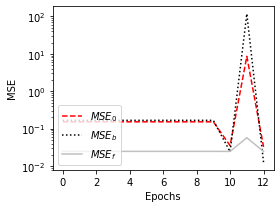

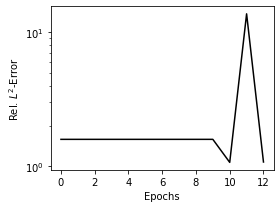

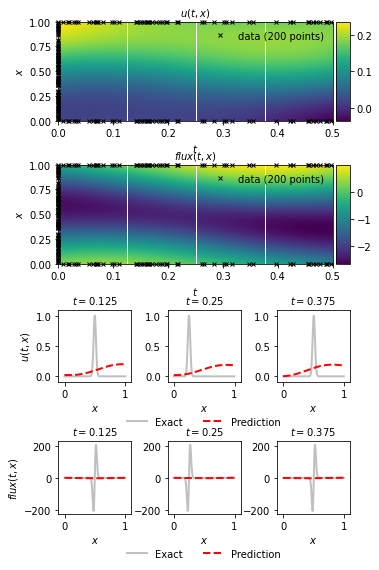

In [ ]:

######################################################################
############################# Plotting ###############################
######################################################################

train_history = np.asarray(train_history, dtype=np.float32)

fig0, ax0 = plt.subplots(figsize=(4, 3))
loss_u0, loss_ub, loss_f = ax0.plot(train_history[:, 1:4])
loss_u0.set(color='r', linestyle='dashed')
loss_ub.set(color='k', linestyle='dotted')
loss_f.set(color='silver')
ax0.set_yscale('log')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('MSE')
plt.legend([loss_u0, loss_ub, loss_f],
          ['$MSE_0$', '$MSE_b$', '$MSE_f$'], loc='lower left')
fig0.tight_layout()
# fig0.savefig('./figures/1Dheat_Neumann_nondim_losses.eps', bbox_inches='tight', pad_inches=0)
# fig0.savefig('./figures/1Dheat_Neumann_nondim_losses.pdf', bbox_inches='tight', pad_inches=0)

fig0, ax0 = plt.subplots(figsize=(4, 3))
error_u = ax0.plot(error_u_history, 'k-')
ax0.set_yscale('log')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Rel. $L^2$-Error')
fig0.tight_layout()
# fig0.savefig('./figures/1Dheat_Neumann_nondim_error.eps', bbox_inches='tight', pad_inches=0)
# fig0.savefig('./figures/1Dheat_Neumann_nondim_error.pdf', bbox_inches='tight', pad_inches=0)

X0 = np.concatenate((x0, 0 * x0), 1)  # (x0, 0)
X_lb = np.concatenate((0 * tb + lb[0], tb), 1)  # (lb[0], tb)
X_ub = np.concatenate((0 * tb + ub[0], tb), 1)  # (ub[0], tb)
X_u_train = np.vstack([X0, X_lb, X_ub])

fig, ax = newfig(1, 1)
ax.axis('off')

####### Row 0: u(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1 - 0.03, bottom=1 - 1 / 4 + 0.04, left=0.15, right=0.9, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='bilinear', cmap='viridis',
            extent=[t.min(), t.max(), x.min(), x.max()],
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# plot data points used for training as 'x'
ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', label='data (%d points)' % (X_u_train.shape[0]), markersize=4,
      clip_on=False)

# white lines on upper plot
line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
# ax.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[100] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[150] * np.ones((2, 1)), line, 'w-', linewidth=1)

# labels and legend for upper plot
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc='best')
ax.set_title('$u(t,x)$', fontsize=10)

####### Row 1: phi(t,x) ##################
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=1 - 1 / 4 - 0.04 , bottom=1 - 1 / 2 + 0.03, left=0.15, right=0.90, wspace=0)
ax = plt.subplot(gs1[:, :])

h = ax.imshow(Flux_pred.T, interpolation='bilinear', cmap='viridis',
            extent=[t.min(), t.max(), x.min(), x.max()],
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# plot data points used for training as 'x'
ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', label='data (%d points)' % (X_u_train.shape[0]), markersize=4,
      clip_on=False)

# white lines on upper plot
line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
# ax.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[100] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[150] * np.ones((2, 1)), line, 'w-', linewidth=1)

# labels and legend for upper plot
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc='best')
ax.set_title('$flux(t,x)$', fontsize=10)

####### Row 2: u(t,x) slices ##################
gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=1 - 1 / 2 - 0.03, bottom=1 - 3 / 4 + 0.04, left=0.15, right=0.9, wspace=0.5)

ax = plt.subplot(gs2[0, 0])
ax.plot(x, Exact[50, :], '-', color='silver', linewidth=2, label='Exact')
ax.plot(x, U_pred[50, :], 'r--', linewidth=2, label='Prediction')
# ax.plot(x, Exact[25, :], 'b-', linewidth=2, label='Exact')
# ax.plot(x, U_pred[25, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = 0.125$', fontsize=10)
ax.axis('square')
ax.set_xlim([lb[0] - 0.1, ub[0] + 0.1])
ax.set_ylim([Exact.min() - 0.1, Exact.max() + 0.1])
ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable='box')

ax = plt.subplot(gs2[0, 1])
ax.plot(x, Exact[100, :], '-', color='silver', linewidth=2, label='Exact')
ax.plot(x, U_pred[100, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
# ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([lb[0] - 0.1, ub[0] + 0.1])
ax.set_ylim([Exact.min() - 0.1, Exact.max() + 0.1])
ax.set_title('$t = 0.25$', fontsize=10)
ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable='box')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)


ax = plt.subplot(gs2[0, 2])
ax.plot(x, Exact[150, :], '-', color='silver', linewidth=2, label='Exact')
ax.plot(x, U_pred[150, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
# ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([lb[0] - 0.1, ub[0] + 0.1])
ax.set_ylim([Exact.min() - 0.1, Exact.max() + 0.1])
ax.set_title('$t = 0.375$', fontsize=10)
ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable='box')

####### Row 3: phi(t,x) slices ##################
gs3 = gridspec.GridSpec(1, 3)
gs3.update(top=1 - 3 / 4 - 0.02, bottom=0.05, left=0.15, right=0.9, wspace=0.5)

ax = plt.subplot(gs3[0, 0])
ax.plot(x, Exact_flux[50, :], '-', color='silver', linewidth=2, label='Exact')
ax.plot(x, Flux_pred[50, :], 'r--', linewidth=2, label='Prediction')
# ax.plot(x, Exact[25, :], 'b-', linewidth=2, label='Exact')
# ax.plot(x, U_pred[25, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$flux(t,x)$')
ax.set_title('$t = 0.125$', fontsize=10)
# ax.axis('square')
ax.set_xlim([lb[0] - 0.1, ub[0] + 0.1])
ax.set_ylim([Exact_flux.min() * (1 + 0.1), Exact_flux.max() * (1 + 0.1)])
ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable='box')

ax = plt.subplot(gs3[0, 1])
ax.plot(x, Exact_flux[100, :], '-', color='silver', linewidth=2, label='Exact')
ax.plot(x, Flux_pred[100, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
# ax.set_ylabel('$\phi(t,x)$')
# ax.axis('square')
ax.set_xlim([lb[0] - 0.1, ub[0] + 0.1])
ax.set_ylim([Exact_flux.min() * (1 + 0.1), Exact_flux.max() * (1 + 0.1)])
ax.set_title('$t = 0.25$', fontsize=10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable='box')

ax = plt.subplot(gs3[0, 2])
ax.plot(x, Exact_flux[150, :], '-', color='silver', linewidth=2, label='Exact')
ax.plot(x, Flux_pred[150, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
# ax.set_ylabel('$\phi(t,x)$')
# ax.axis('square')
ax.set_xlim([lb[0] - 0.1, ub[0] + 0.1])
ax.set_ylim([Exact_flux.min() * (1 + 0.1), Exact_flux.max() * (1 + 0.1)])
ax.set_title('$t = 0.375$', fontsize=10)
ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable='box')

# savefig('./figures/1Dheat_Neumann_nondim',crop=False)
# plt.show()